In [3]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from iminuit import Minuit


from utils import *


import seaborn as sns
from matplotlib import rcParams
from cycler import cycler


## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 20, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'brown', 'green', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [6]:
class AnalyseDefects:
    def __init__(self, input_list, output_path = 'data') -> None:
        """"
        input_list: list of dictionaries. Each dictionary contains the following keys:
        "path": path to the defect folder
        "suffix": suffix of the defect folder
        "priority": int: defect priority. The higher the more important and will overwrite the lower priority results
        "LX": int: system size in x direction
        "Nframes": int: number of frames in the defect folder

        """
        self.Ndata = len(input_list)
        self.input_list = input_list
        self.input_paths = [input["path"] for input in input_list]
        self.suffixes = [input["suffix"] for input in input_list]
        self.priorities = [input["priority"] for input in input_list]
        self.LX = [int(input["LX"]) for input in input_list]
        self.Nframes = [int(input["Nframes"]) for input in input_list]

        self.output_main_path = output_path 
        self.output_paths = [os.path.join(self.output_main_path, self.suffixes[i]) for i in range(self.Ndata)]
        self.Nexp = []
        self.Nactivity = []
        self.act_list = []
        self.act_dir_list = []
        self.window_sizes = []
        self.conv_list = []
        
        self.Ndata = len(input_list)

        
        for i, input in enumerate(self.input_paths):
            Nsubdir = 1
            act = []
            act_dir = []
            self.Nactivity.append(len(os.listdir(input)))
            for j, subdir in enumerate(os.listdir(input)):
        
                subdir_full = os.path.join(input, subdir)
                act.append(np.round(float(subdir_full.split('_')[-1]),4))
                act_dir.append(subdir_full)
                Nsubdir = max(Nsubdir, len(os.listdir(os.path.join(input, subdir))))

                if j == 0:
                    subsubdir = os.path.join(subdir_full, os.listdir(subdir_full)[0])
                    dir_windows = os.path.join(subsubdir, 'window_sizes.txt')
                    windows = np.loadtxt(dir_windows)
                    self.window_sizes.append(windows)

                    if not os.path.isdir(self.output_paths[i]):
                        os.makedirs(self.output_paths[i])

                    # save the window sizes
                    np.savetxt(os.path.join(self.output_paths[i], 'window_sizes.txt'), windows)

            act, act_dir = zip(*sorted(zip(act, act_dir)))

            # save the activity list
            np.savetxt(os.path.join(self.output_paths[i], 'activity_list.txt'), act)

            self.act_list.append(act)
            self.act_dir_list.append(act_dir)
            self.Nexp.append(Nsubdir)

        for i, output in enumerate(self.output_paths):
            if not os.path.exists(output):
                os.makedirs(output)

            # load the convergence list if it exists
            try:
                self.conv_list.append(np.loadtxt(os.path.join(output, 'conv_list.txt').astype(int)))
            except:
                self.conv_list.append([0] * self.Nactivity[i])

    def extract_results(self, save = True, normalize = True):
        """
        Analyse the defects for all the input folders
        """
        for N in range(self.Ndata):

            defect_arr = np.nan * np.zeros((self.Nframes[N], self.Nactivity[N], self.Nexp[N]))
            av_counts = np.nan * np.zeros([self.Nframes[N], len(self.window_sizes[N]), self.Nactivity[N], self.Nexp[N]])
            var_counts = np.nan * np.zeros_like(av_counts)
            
            print('Analyse defects for input folder {}'.format(self.input_paths[N]))
            for i, (act, act_dir) in enumerate(zip(self.act_list[N], self.act_dir_list[N])):
                exp_list = []
                exp_dir_list = []

                for file in os.listdir(act_dir):
                    exp_count = file.split('_')[-1]
                    exp_list.append(int(exp_count))
                    exp_dir_list.append(os.path.join(act_dir, file))

                # sort the activity list and the activity directory list
                exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

                for exp, exp_dir in zip(exp_list, exp_dir_list):
                    defect_arr[:, i, exp] = np.loadtxt(os.path.join(exp_dir, 'Ndefects_act{}_exp{}.txt'.format(act, exp)))[-self.Nframes[N]:]

                    counts = np.loadtxt(os.path.join(exp_dir, 'av_counts_act{}_exp{}.txt'.format(act,exp)))[-self.Nframes[N]:,:]
                    vars = np.loadtxt(os.path.join(exp_dir, 'count_fluctuations_act{}_exp{}.txt'.format(act,exp)))[-self.Nframes[N]:,:]

                    idx_start_count = min(self.Nframes[N], len(counts))
                    av_counts[-idx_start_count:, :, i, exp] = counts[-idx_start_count:, :]
                    var_counts[-idx_start_count:, :, i, exp] = vars[-idx_start_count:, :]

            dens_fluc = var_counts / (np.pi * self.window_sizes[N][:, None, None] ** 2) ** 2
            if normalize:
                dens_fluc = dens_fluc / defect_arr[:, None, :, :] ** 2

            if save:
                np.save(os.path.join(self.output_paths[N], 'defect_arr.npy'), defect_arr)
                np.save(os.path.join(self.output_paths[N], 'av_counts.npy'), av_counts)
                np.save(os.path.join(self.output_paths[N], 'var_counts.npy'), var_counts)
                np.save(os.path.join(self.output_paths[N], 'dens_fluc.npy'), dens_fluc)

    def analyze_defects(self, Ndataset_list = None, save = True,):
        Ndataset_list = range(self.Ndata) if Ndataset_list is None else Ndataset_list

        for N in Ndataset_list:
            while True:
                try:
                    defect_arr = np.load(os.path.join(self.output_paths[N], 'defect_arr.npy'))
                    av_counts = np.load(os.path.join(self.output_paths[N], 'av_counts.npy'))
                    var_counts = np.load(os.path.join(self.output_paths[N], 'var_counts.npy'))
                    dens_fluc = np.load(os.path.join(self.output_paths[N], 'dens_fluc.npy'))
                    break
                except:
                    print('Defect array not found. They will be extracted now using normalize = True')
                    self.extract_results(save = True, normalize = True)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                defect_arr_av = np.nanmean(defect_arr, axis = -1)
                defect_arr_std = np.nanstd(defect_arr, axis = -1) / np.sqrt(self.Nexp[N])
                av_counts_av = np.nanmean(av_counts, axis = -1)
                av_counts_std = np.nanstd(av_counts, axis = -1) / np.sqrt(self.Nexp[N])
                var_counts_av = np.nanmean(var_counts, axis = -1)
                var_counts_std = np.nanstd(var_counts, axis = -1) / np.sqrt(self.Nexp[N])
                dens_fluc_av = np.nanmean(dens_fluc, axis = -1)
                dens_fluc_std = np.nanstd(dens_fluc, axis = -1) / np.sqrt(self.Nexp[N])

            av_defects = np.zeros((self.Nactivity[N], 2))

            for i, act in enumerate(self.act_list[N]):
                av_defects[i, 0] = np.mean(defect_arr_av[self.conv_list[N][i]:, i])
                av_defects[i, 1] = np.mean(defect_arr_std[self.conv_list[N][i]:, i]) / np.sqrt(self.Nframes[N] - self.conv_list[N][i])
 
            if save:
                np.save(os.path.join(self.output_paths[N], 'defect_arr_av.npy'), defect_arr_av)
                np.save(os.path.join(self.output_paths[N], 'defect_arr_std.npy'), defect_arr_std)
                np.save(os.path.join(self.output_paths[N], 'av_counts_av.npy'), av_counts_av)
                np.save(os.path.join(self.output_paths[N], 'av_counts_std.npy'), av_counts_std)
                np.save(os.path.join(self.output_paths[N], 'var_counts_av.npy'), var_counts_av)
                np.save(os.path.join(self.output_paths[N], 'var_counts_std.npy'), var_counts_std)
                np.save(os.path.join(self.output_paths[N], 'dens_fluc_av.npy'), dens_fluc_av)
                np.save(os.path.join(self.output_paths[N], 'dens_fluc_std.npy'), dens_fluc_std)
                np.save(os.path.join(self.output_paths[N], 'av_defects.npy'), av_defects)
        return

    def plot_av_defects(self, Ndataset = 0, fit_dict = {}, plot_density = True, verbose = False, use_merged = False):
        """
        fit_dict: dictionary containing the fit parameters with keys
        'fit_func': fit function
        'fit_string': string of the fit function
        'lower_act_index': index of the activity list to start the fit
        'param_guess': guess for the fit parameters
        """

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        if fit_dict == {}:
            do_fit = False
        else:
            do_fit = True
            fit_func = fit_dict['fit_func']
            fit_string = fit_dict['fit_string']
            lower_act_index = fit_dict['lower_act_index']
            param_guess = fit_dict['param_guess']

        norm = self.LX[Ndataset] ** 2 if plot_density else 1

        try:
            av_defects = np.load(os.path.join(output_path, 'av_defects.npy')) / norm
        except:
            print('Average defects not found. Analyse defects first.')
            return
        print(av_defects)
        fig, ax = plt.subplots(figsize=(9, 6))
        ax.errorbar(self.act_list[Ndataset], av_defects[:, 0], yerr = av_defects[:, 1], fmt = 'k.', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4)
        
        ax.set_xlabel(r'$\zeta$')
        ax.set_ylabel(r'$\langle \rho \rangle$')
        ax.set_title('Average defect density vs. activity')

        if do_fit:
            activities = np.array(self.act_list[Ndataset][lower_act_index:])
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)

                fit = do_chi2_fit(fit_func, activities, av_defects[lower_act_index:, 0], \
                              av_defects[lower_act_index:, 1], parameter_guesses = param_guess, verbose=verbose)
                d = generate_dictionary(fit, len(activities), chi2_suffix = None)
                text = nice_string_output(d, extra_spacing=4, decimals=3)
                add_text_to_ax(0.02, 0.96, text, ax, fontsize=14)

            ax.plot(activities, fit_func(activities, *fit.values[:]), 'r--', label=rf'Fit: {fit_string}')
            ax.legend(loc='lower right')

        fig.tight_layout()
        plt.show()
        
    def plot_defects_per_activity(self, Ndataset = 0, Nfirst_frame = 0, act_min_idx = None, act_max_idx = None, plot_density = False, use_merged = False):
        
        if use_merged: 
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        act_min_idx = 0 if act_min_idx is None else act_min_idx
        activities = self.act_list[Ndataset][act_min_idx:act_max_idx] 
        norm = self.LX[Ndataset] ** 2 if plot_density else 1
        Nframes = self.Nframes[Ndataset] - Nfirst_frame

        try:
            defect_arr_av = np.load(os.path.join(output_path, 'defect_arr_av.npy'))[-Nframes:] / norm
            defect_arr_std = np.load(os.path.join(output_path, 'defect_arr_std.npy'))[-Nframes:] / norm
        except:
            print('Defect array not found. Analyse defects first.')
            return

        ncols = 4
        nrows = int(np.ceil(len(activities) / ncols))
        title = 'Defect density' if plot_density else 'Defect count'
        height = nrows * 4
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20,height))
        ax = ax.flatten()  

        for i, act in enumerate(activities):
            ax[i].errorbar(np.arange(Nframes), defect_arr_av[:, i], defect_arr_std[:, i], fmt='.', \
                            alpha = 0.15, markersize=9, label='Activity = {}'.format(act),)
            ax[i].legend()  

            # plot vertical lines to indicate the start of the averaging
            x=self.conv_list[Ndataset][i + act_min_idx] - Nfirst_frame
            if x > 0:
                ax[i].axvline(x=self.conv_list[Ndataset][i + act_min_idx], color='black', linestyle='--', alpha=0.5)
            ax[i].set_ylim(0, np.max(defect_arr_av[:, i]) * 1.8)

        fig.suptitle(f'{title} for different activities' , fontsize=22, y = 1)
        fig.supxlabel('Frame', fontsize=20, y = 0)
        fig.supylabel(f'{title}', fontsize=20, x=0)
        fig.tight_layout()
        plt.show()
        return fig, ax
    
    def update_conv_list(self, Ndataset_list = None):
        if Ndataset_list is None:
            Ndataset_list = range(self.Ndata)
        
        for i in Ndataset_list:
            fig, ax = self.plot_defects_per_activity(Ndataset = i, act_min_idx = 0, act_max_idx = None, plot_density = False)
            
            for j in range(self.Nactivity[i]):
                self.conv_list[i][j] = int(input(f'Enter the first frame to use for activity {self.act_list[i][j]}: '))

            # save the convergence list
            np.savetxt(os.path.join(self.output_paths[i], 'conv_list.txt'), self.conv_list[i])

    def plot_defects_per_exp(self, Ndataset = 0, act_min_idx = None, act_max_idx = None, plot_density = False):

        try:
            act_min_idx = 0 if act_min_idx is None else act_min_idx
            activities = self.act_list[Ndataset][act_min_idx:act_max_idx]
            norm = self.LX[Ndataset] ** 2 if plot_density else 1

            try:
                defect_arr = np.load(os.path.join(self.output_paths[Ndataset], 'defect_arr.npy'))
            except:
                print('Defect array not found. Analyse defects first.')
                return

            ncols = 4
            nrows = int(np.ceil(self.Nexp[Ndataset] / ncols))
            norm = self.LX[Ndataset] ** 2 if plot_density else 1
            title = 'Defect density' if plot_density else 'Defect count'

            for i, act in enumerate(activities):
                fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(22,13))
                ax = ax.flatten()  
                defect_arr_act = (defect_arr[:, i, :] / norm).astype(float)
                mini, maxi = np.nanmin(defect_arr_act) * 0.3, np.nanmax(defect_arr_act) * 1.5

                for j in np.arange(self.Nexp[Ndataset]):
                    ax[j].plot(np.arange(self.Nframes[Ndataset]), defect_arr_act[:, j], '.', label='Exp = {}'.format(j), alpha = 0.5)
                    ax[j].legend()  

                    ax[j].set_ylim(0, maxi)

                fig.suptitle(f'{title} for activity = {act}' , fontsize=18)
                fig.supxlabel('Frame', fontsize=18)
                fig.supylabel(f'{title}', fontsize=18)
                fig.tight_layout()
                plt.show()
        except:
            raise KeyboardInterrupt

    def merge_results(self, save_path = None, save = True):

        if save_path is None:
            save_path = os.path.join(self.output_main_path, 'merged_results')
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        Nbase = np.argmin(self.priorities)
        Nbase_frames = self.Nframes[Nbase]

        try:
            # load the results from the base dataset
            defect_arr_av = np.load(os.path.join(self.output_paths[Nbase], 'defect_arr_av.npy'))
            defect_arr_std = np.load(os.path.join(self.output_paths[Nbase], 'defect_arr_std.npy'))
            av_counts_av = np.load(os.path.join(self.output_paths[Nbase], 'av_counts_av.npy'))  
            av_counts_std = np.load(os.path.join(self.output_paths[Nbase], 'av_counts_std.npy'))
            var_counts_av = np.load(os.path.join(self.output_paths[Nbase], 'var_counts_av.npy'))
            var_counts_std = np.load(os.path.join(self.output_paths[Nbase], 'var_counts_std.npy'))
            dens_fluc_av = np.load(os.path.join(self.output_paths[Nbase], 'dens_fluc_av.npy'))
            dens_fluc_std = np.load(os.path.join(self.output_paths[Nbase], 'dens_fluc_std.npy'))
            av_defects = np.load(os.path.join(self.output_paths[Nbase], 'av_defects.npy'))
        except:
            print('Base dataset not found. Analyse defects first.')
            return

        # overwrite the activities with the ones from the other datasets according to self.priorities
        priorities, Nsorted = zip(*sorted(zip(self.priorities, range(self.Ndata))))

        for N in Nsorted[1:]:
            act_min, act_max = self.act_list[N][0], self.act_list[N][-1]
            act_min_idx = self.act_list[Nbase].index(act_min)
            act_max_idx = self.act_list[Nbase].index(act_max) + 1

            defect_arr_av[:, act_min_idx:act_max_idx] = np.load(os.path.join(self.output_paths[N], 'defect_arr_av.npy'))[-Nbase_frames:]
            defect_arr_std[:, act_min_idx:act_max_idx] = np.load(os.path.join(self.output_paths[N], 'defect_arr_std.npy'))[-Nbase_frames:]

            var_counts_av[:, :, act_min_idx:act_max_idx] = np.load(os.path.join(self.output_paths[N], 'var_counts_av.npy'))[-Nbase_frames:]
            var_counts_std[:, :, act_min_idx:act_max_idx] = np.load(os.path.join(self.output_paths[N], 'var_counts_std.npy'))[-Nbase_frames:]

            dens_fluc_av[:, :, act_min_idx:act_max_idx] = np.load(os.path.join(self.output_paths[N], 'dens_fluc_av.npy'))[-Nbase_frames:]
            dens_fluc_std[:, :, act_min_idx:act_max_idx] = np.load(os.path.join(self.output_paths[N], 'dens_fluc_std.npy'))[-Nbase_frames:]

            av_counts_av[:, :, act_min_idx:act_max_idx] = np.load(os.path.join(self.output_paths[N], 'av_counts_av.npy'))[-Nbase_frames:]
            av_counts_std[:, :, act_min_idx:act_max_idx] = np.load(os.path.join(self.output_paths[N], 'av_counts_std.npy'))[-Nbase_frames:]

            av_defects[act_min_idx:act_max_idx] = np.load(os.path.join(self.output_paths[N], 'av_defects.npy'))
            
        if save:
            np.save(os.path.join(save_path, 'defect_arr_av.npy'), defect_arr_av)
            np.save(os.path.join(save_path, 'defect_arr_std.npy'), defect_arr_std)
            np.save(os.path.join(save_path, 'av_counts_av.npy'), av_counts_av)
            np.save(os.path.join(save_path, 'av_counts_std.npy'), av_counts_std)
            np.save(os.path.join(save_path, 'var_counts_av.npy'), var_counts_av)
            np.save(os.path.join(save_path, 'var_counts_std.npy'), var_counts_std)
            np.save(os.path.join(save_path, 'dens_fluc_av.npy'), dens_fluc_av)
            np.save(os.path.join(save_path, 'dens_fluc_std.npy'), dens_fluc_std)
            np.save(os.path.join(save_path, 'av_defects.npy'), av_defects)
        return
    
    def analyze_hyperuniformity(self, Ndataset = 0, fit_densities = False, fit_dict = {}, window_idx_bounds = None, \
                                act_bounds = None, use_merged = False, save = True, plot = True):
        
        suffix = 'dens' if fit_densities else 'count'

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        if window_idx_bounds is None:
            window_idx_bounds = [0, len(self.window_sizes[Ndataset])]
        if act_bounds is None:
            act_bounds = [0, len(self.act_list[Ndataset])]

        window_sizes = self.window_sizes[Ndataset][window_idx_bounds[0]:window_idx_bounds[1]]
        act_list = self.act_list[Ndataset][act_bounds[0]:act_bounds[1]]
        if fit_densities:
            try:
                var_av = np.load(os.path.join(output_path, 'dens_fluc_av.npy'))[:, window_idx_bounds[0]:window_idx_bounds[1], act_bounds[0]:act_bounds[1]]
                var_std = np.load(os.path.join(output_path, 'dens_fluc_std.npy'))[:, window_idx_bounds[0]:window_idx_bounds[1], act_bounds[0]:act_bounds[1]]
            except:
                print('Density fluctuations not found. Analyse defects first.')
                return
        else:
            try:
                var_av = np.load(os.path.join(output_path, 'var_counts_av.npy'))[:, window_idx_bounds[0]:window_idx_bounds[1], act_bounds[0]:act_bounds[1]]
                var_std = np.load(os.path.join(output_path, 'var_counts_std.npy'))[:, window_idx_bounds[0]:window_idx_bounds[1], act_bounds[0]:act_bounds[1]]
            except:
                print('Variance of counts not found. Analyse defects first.')
                return

        if fit_dict == {}:
            if fit_densities:
                def fit_func(x, alpha, beta):
                    return beta * (- 2 - alpha) + (- 2 - alpha) * x
                param_guess = np.array([-0.1, 10])
                fit_string = rf'$y = \beta(2-\alpha) + (2-\alpha)x$'
            else:
                def fit_func(x, alpha, beta):
                    return beta * (2 - alpha) + (2 - alpha) * x
                param_guess = np.array([0.1, 0.3])
                fit_string = rf'$y = \beta(2-\alpha) + (2-\alpha)x$'
        else:
            fit_func = fit_dict['fit_func']
            param_guess = fit_dict['param_guess']
            fit_string = fit_dict['fit_string']

        Nparams = len(param_guess)
            
        fit_params = np.zeros([self.Nframes[Ndataset], len(act_list), 2 * Nparams]) * np.nan
        stat_arr = np.zeros([self.Nframes[Ndataset], len(act_list), 3]) * np.nan

        for i, act in enumerate(act_list):
            for frame in range(self.conv_list[Ndataset][i], self.Nframes[Ndataset]):
                count_var_av = var_av[frame, :, i]
                count_var_std = var_std[frame, :, i]
                zero_mask = (count_var_av > 0) & (count_var_std > 0)

                if len(count_var_av[zero_mask]) < 10:
                    continue

                try:
                    x = np.log(window_sizes[zero_mask])
                    y = np.log(count_var_av[zero_mask])
                    yerr = count_var_std[zero_mask] / count_var_av[zero_mask]
                except:
                    continue
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
                    fit = do_chi2_fit(fit_func, x, y, yerr, param_guess, verbose = False)

                stat_arr[frame, i, :] = get_statistics_from_fit(fit, len(x), subtract_1dof_for_binning = False)
                fit_params[frame, i, :Nparams] = fit.values[:]
                fit_params[frame, i, Nparams:] = fit.errors[:]

           #  x = fit_params[self.conv_list[Ndataset][i]:, i, 0]
          #  mean, err, _ = calc_weighted_mean_vec(x, fit_params[self.conv_list[Ndataset][i]:, i, Nparams])

        print("Non-converged fits (p < 0.05): ", np.nansum((stat_arr[:, :, -1] < 0.05)))

        if save:
            np.save(os.path.join(output_path, f'fit_params_{suffix}.npy'), fit_params)
            np.save(os.path.join(output_path, f'stat_arr_{suffix}.npy'), stat_arr)
        if plot:
            self.plot_hyperuniformity_exp_all(fit_params = fit_params, stat_arr = stat_arr, Ndataset = Ndataset, \
                                              window_idx_bounds = window_idx_bounds, act_bounds = act_bounds, use_merged = use_merged)
        return fit_params, stat_arr

    def plot_hyperuniformity_exp_all(self, fit_params = None, stat_arr = None, Ndataset = 0, window_idx_bounds = None, act_bounds = None, use_merged = False):

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        if act_bounds is None:
            act_bounds = [0, len(self.act_list[Ndataset])]

        act_list = self.act_list[Ndataset][act_bounds[0]:act_bounds[1]]

        if isinstance(fit_params, np.ndarray) and isinstance(stat_arr, np.ndarray):
            pass
        else:
            fit_params = np.load(os.path.join(output_path, 'fit_params.npy'))
            stat_arr = np.load(os.path.join(output_path, 'stat_arr.npy'))

        if not len(act_list) == fit_params.shape[1]:
            print('The number of activities does not match the number of activities in the fit_params array.')
            return
        
        Nframes = fit_params.shape[0]
        Nparams = int(fit_params.shape[-1] / 2)
        Ngroup = 5

        ncols = 4
        nrows = int(np.ceil(len(act_list) / ncols))
        height = nrows * 4
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20,height))
        ax = ax.flatten()  

        for i, act in enumerate(act_list):
            if i == 0:
                label1 = rf'$\chi^2$ fit p-value > 0.05'
                label2 = rf'$\chi^2$ fit p-value < 0.05'
                label3 = 'Weighted mean'
                label4 = 'Grouped mean'
            else:
                label1 = None
                label2 = None
                label3 = None
                label4 = None

            p_mask = stat_arr[self.conv_list[Ndataset][i]:, i, 2] > 0.05
            
            ax[i].errorbar(np.arange(self.conv_list[Ndataset][i], Nframes)[p_mask], \
                        fit_params[self.conv_list[Ndataset][i]:,i,0][p_mask], \
                            fit_params[self.conv_list[Ndataset][i]:,i,Nparams][p_mask], \
                            fmt='.', \
                        alpha = 0.3, markersize=2, label = label1)
            
            ax[i].errorbar(np.arange(self.conv_list[Ndataset][i], Nframes)[~p_mask], \
                            fit_params[self.conv_list[Ndataset][i]:,i,0][~p_mask], \
                            fit_params[self.conv_list[Ndataset][i]:,i,Nparams][~p_mask], \
                                fmt='r.', \
                            capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.6, markersize=2, ecolor='red', label = label2)

            x = fit_params[self.conv_list[Ndataset][i]:, i, 0]
            max_idx = len(x) - len(x) % Ngroup 

            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)

                x_group = np.nanmean(x[:max_idx].reshape(-1, Ngroup), axis=1)
                dx_group = np.nanstd(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)
                x_frames = np.arange(self.conv_list[Ndataset][i], self.conv_list[Ndataset][i] + max_idx, Ngroup) + Ngroup / 2

                if len(x_group < 10) > 10:
                    ax[i].plot(x_frames, x_group, '.-', color='orange', alpha=0.8, markersize=4, label = label4)
                
                mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x, fit_params[self.conv_list[Ndataset][i]:, i, Nparams])
            
            ax[i].axhline(mean, color='green', linestyle='--', alpha=0.5, lw = 2, label = label3)
            ax[i].text(0.05, 0.97, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=12, verticalalignment='top')

        fig.suptitle('Hyperuniformity exponent for different activities', y=1.05)
        fig.supxlabel('Frame')
        fig.supylabel(rf'$\alpha$')
        fig.legend(ncol=4, fontsize = 13,bbox_to_anchor=(0.75, 1.02))

        plt.tight_layout()
        plt.show()
        return fig, ax

#### HÅNDTER NFRAMES IFT MERGE (og evt ift saving og initialisering på en god måde.)
### TILFØJ VALG IFT OM COUNT ELLER DENS SKAL FITTES
    ### REGN ALPHA MEAN I ANALYZE_HYP
    # ++++++ INCLUDE ONLY CONV.
### LAV EN PLOT ALPHA MEAN
# EVT EN DENS FLUK PLOT



Non-converged fits (p < 0.05):  864


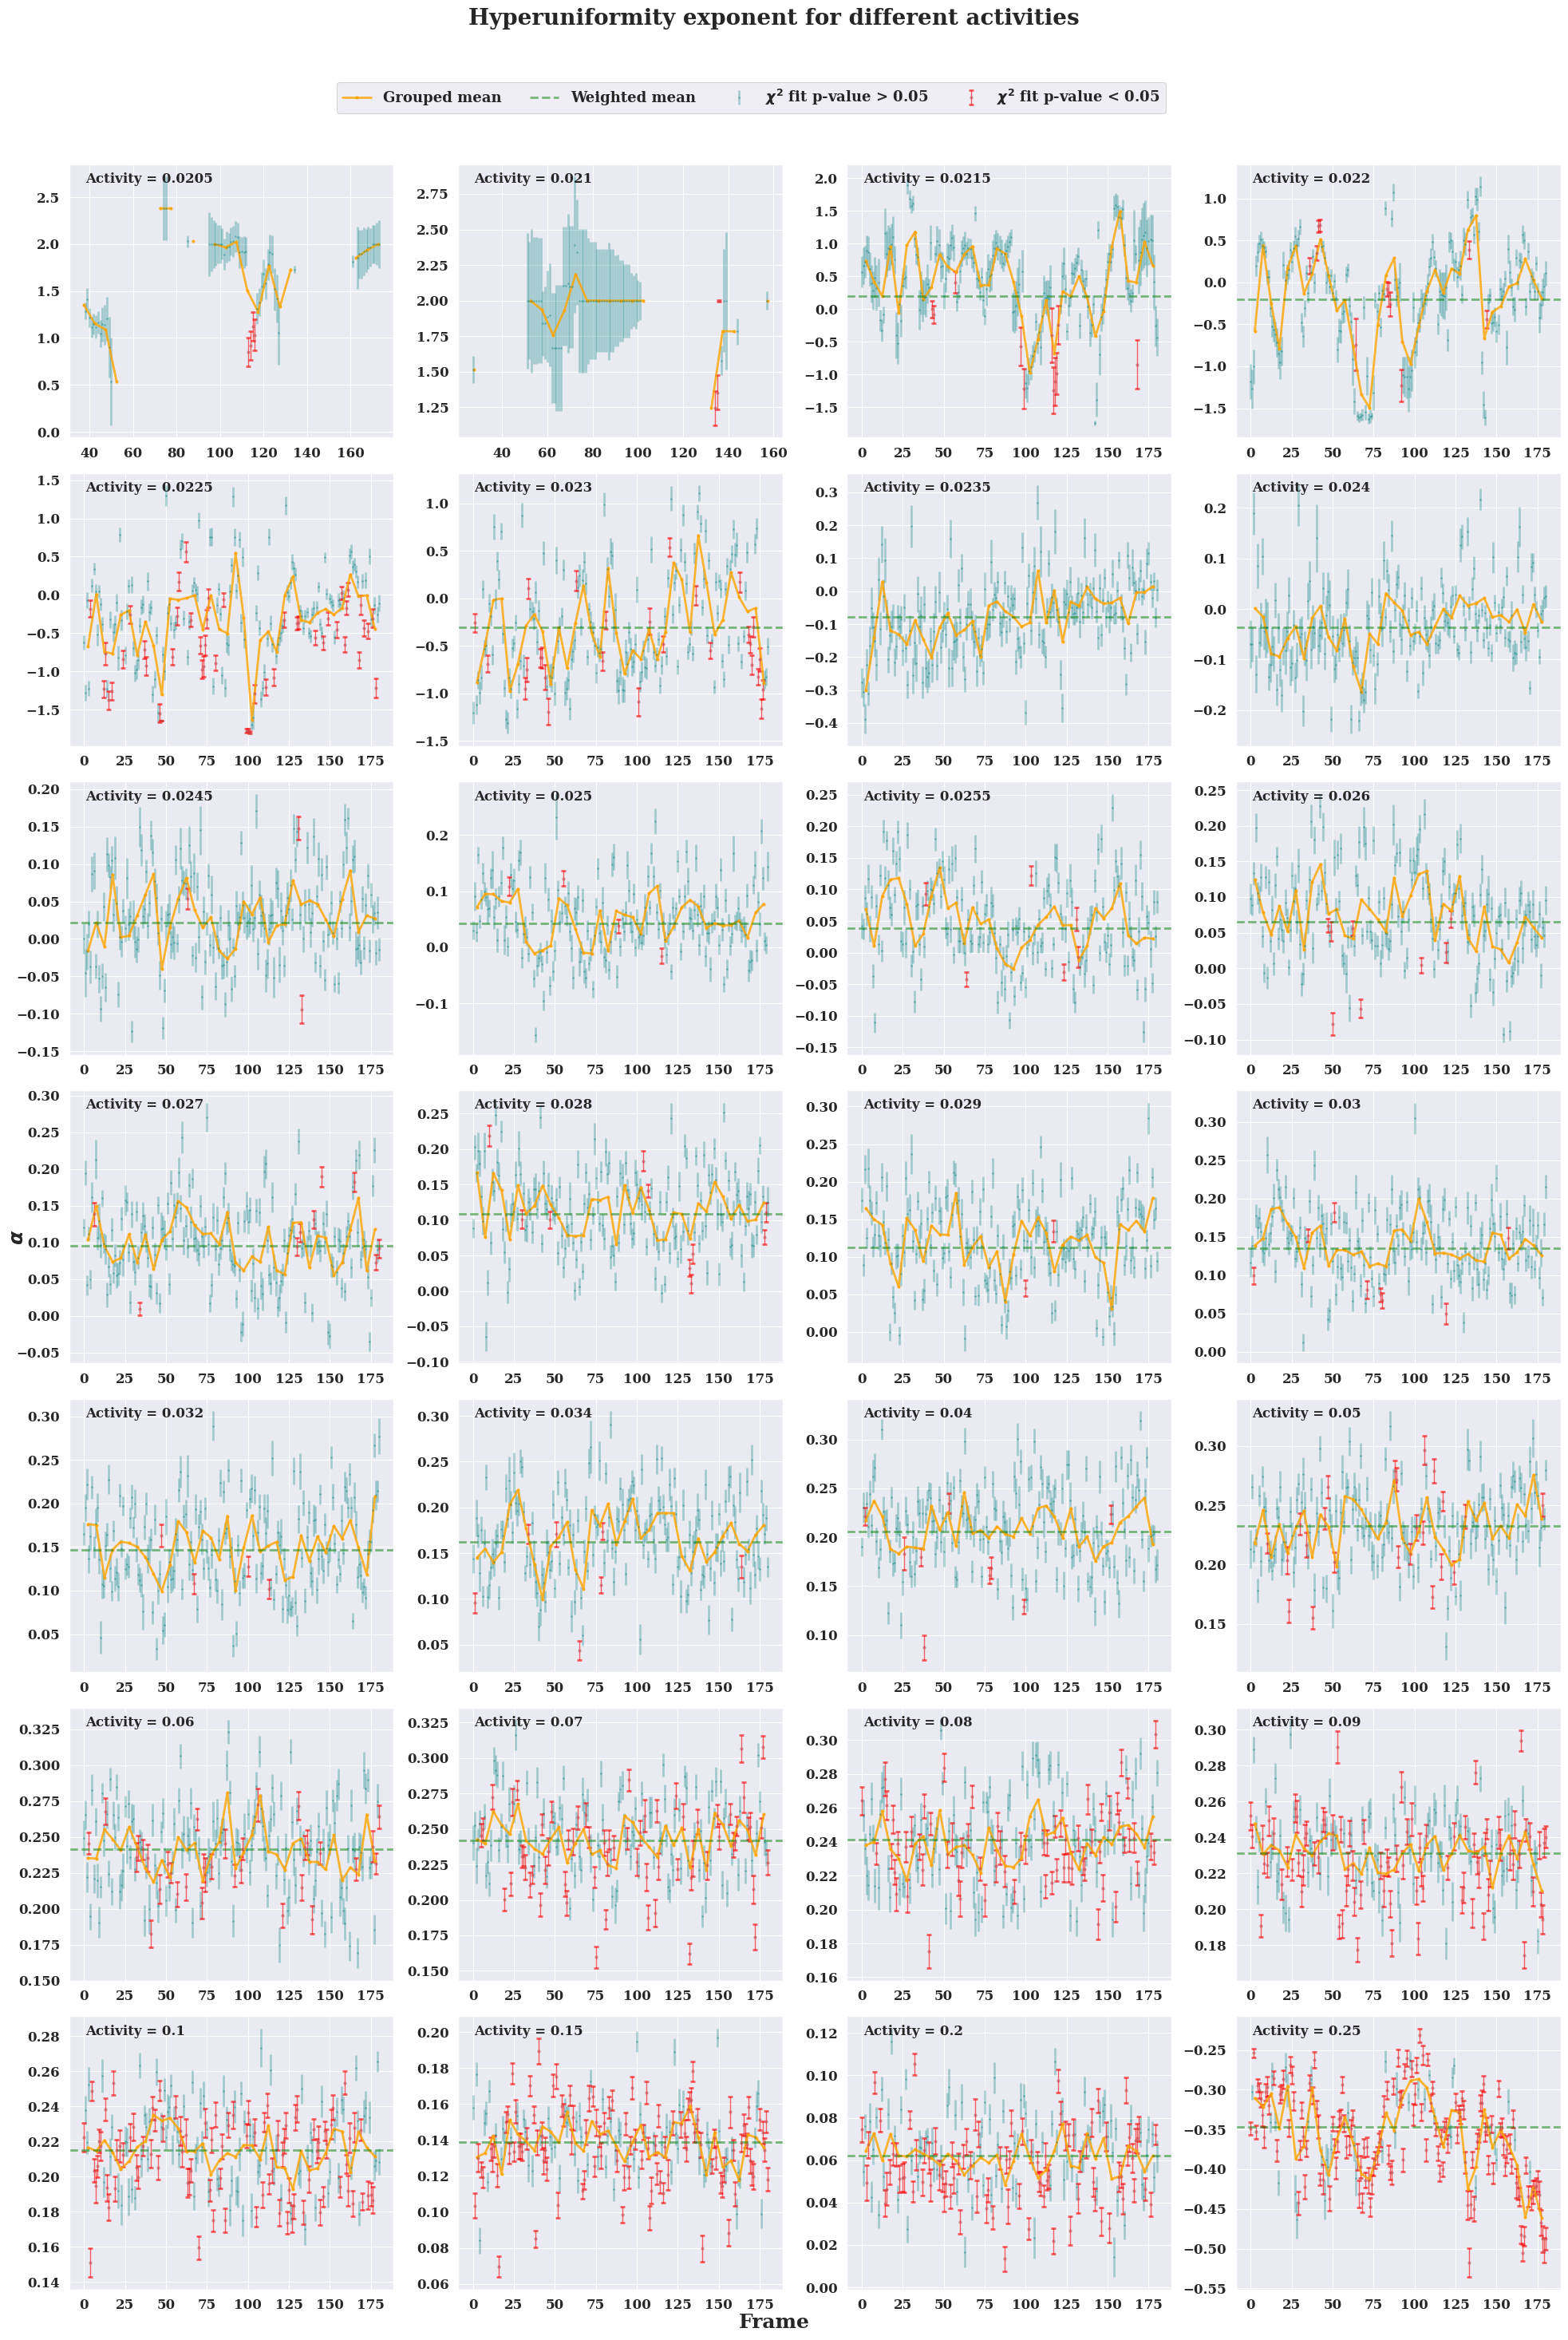

In [7]:
LL = 512
dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
             suffix = "long", priority = 0, LX = LL, Nframes = 400)
dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                   suffix = "very_long", priority = 3, LX = LL, Nframes = 1500)
dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                   suffix = "very_long2", priority = 2, LX = LL, Nframes = 1500)
defect_list = [dshort, dlong, dvery_long,dvery_long2]
#defect_list = [dshort]
output_path = f'data\\nematic_analysis{LL}_LL0.05'


def log_func(x, a, b, c):
    return a * np.log(x) + b*x + c
fit_string = rf'$y = a \ln x + bx + c $'
fit_dict = dict(fit_func = log_func, fit_string = fit_string, lower_act_index = 12, param_guess = np.array([0.005, 0.04,0.015]))

ad = AnalyseDefects(defect_list, output_path=output_path)
#ad.plot_defects_per_activity(Ndataset=2, use_merged=True)
#ad.extract_results()
#ad.analyze_defects()
#ad.merge_results()
#ad.plot_defects_per_activity(Ndataset=2, Nfirst_frame=1300, use_merged=False)

fitp, statp = ad.analyze_hyperuniformity(Ndataset=0, fit_densities=True, save = True, plot = True, use_merged = False,act_bounds=[8,None]); #window_idx_bounds=[3, -3]);

In [ ]:
ad.plot_defects_per_activity(use_merged=True)

Non-converged fits (p < 0.05):  324
Non-converged fits (p < 0.05):  82
Non-converged fits (p < 0.05):  48
Non-converged fits (p < 0.05):  0


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8056\2234096850.py:7: RuntimeWarning: Mean of empty slice
  ax.plot(ad.act_list[0][8:-2], np.nanmean(fitp[:,:,0], axis = 0), '.-', label = f'{window[0]}:{window[1]}')


Non-converged fits (p < 0.05):  6
Non-converged fits (p < 0.05):  78
Non-converged fits (p < 0.05):  12
Non-converged fits (p < 0.05):  37
Non-converged fits (p < 0.05):  13
Non-converged fits (p < 0.05):  20


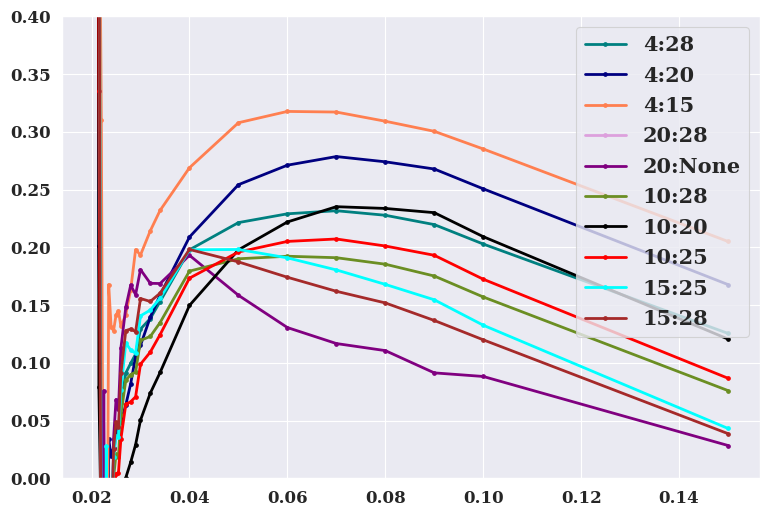

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))
minn = 4
maxx = 28
window_idx_bounds_list=[[minn, maxx], [minn, 20], [minn, 15], [20, maxx], [20, None], [10, maxx], [10, 20], [10, 25], [15,25], [15, maxx]]
for window in window_idx_bounds_list:
    fitp, statp = ad.analyze_hyperuniformity(Ndataset=0, fit_densities=True, save = False, plot = False, act_bounds=[8,-2], use_merged = False, window_idx_bounds=window);
    ax.plot(ad.act_list[0][8:-2], np.nanmean(fitp[:,:,0], axis = 0), '.-', label = f'{window[0]}:{window[1]}')
ax.set_ylim([0,0.4])
ax.legend()

In [ ]:
#ad.analyze_defects()
ad.plot_defects_per_activity(Ndataset=2, use_merged=False)

c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


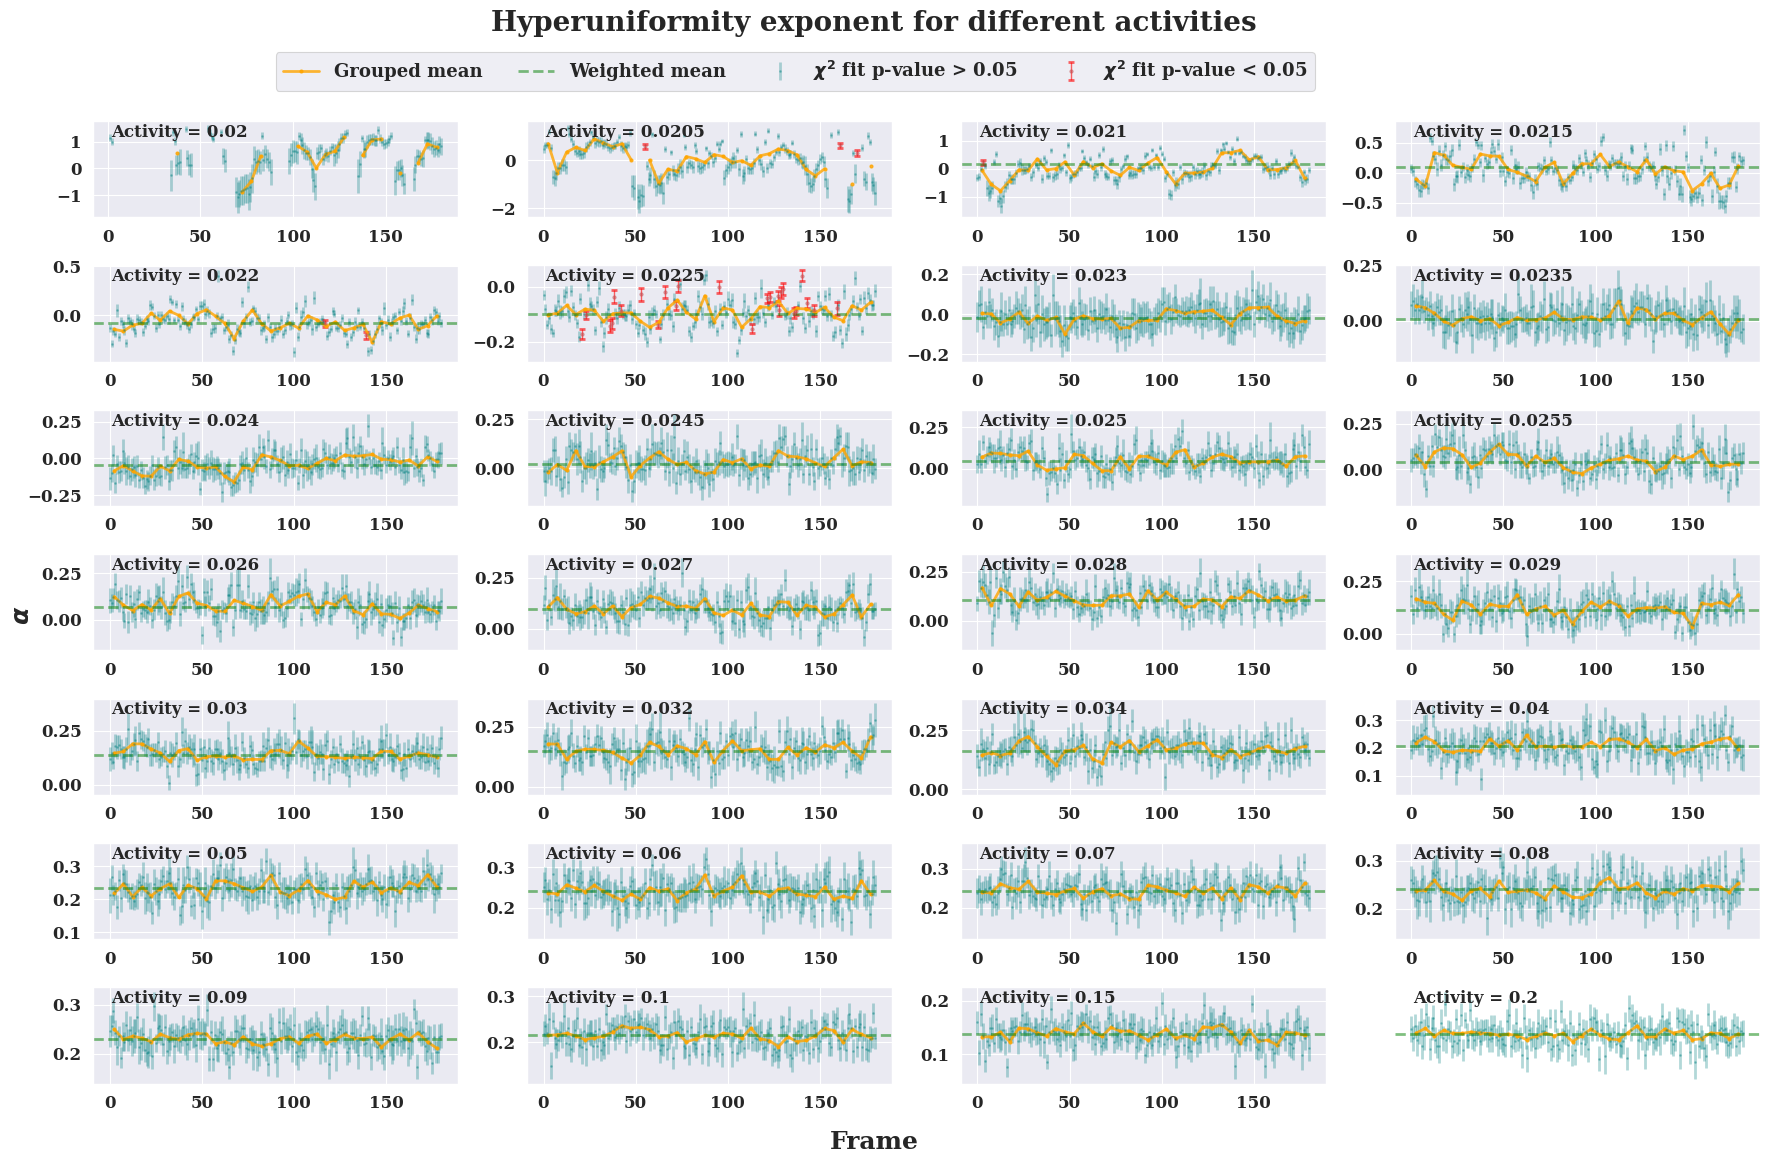

In [95]:
fig, ax = plt.subplots(nrows = 7, ncols = 4, figsize=(18, 11))

ax = ax.flatten()
Ngroup = 5

for i, act in enumerate(act_list[min_act_idx+1:min_act_idx+1+28]):
    act_idx = act_list.index(act)
    
    if i == 0:
        label1 = rf'$\chi^2$ fit p-value > 0.05'
        label2 = rf'$\chi^2$ fit p-value < 0.05'
        label3 = 'Weighted mean'
        label4 = 'Grouped mean'
    else:
        label1 = None
        label2 = None
        label3 = None
        label4 = None

    p_mask = stat_arr[first_frame_list[act_idx]:, act_idx, 2] > 0.05

    ax[i].errorbar(np.arange(first_frame_list[act_idx], Nframes)[p_mask], \
                   fit_params[first_frame_list[act_idx]:,act_idx,0][p_mask], \
                    fit_params[first_frame_list[act_idx]:,act_idx,Nparams][p_mask], \
                       fmt='.', \
                   alpha = 0.3, markersize=2, label = label1)# ecolor='black')capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, 
    
    ax[i].errorbar(np.arange(first_frame_list[act_idx], Nframes)[~p_mask], \
                     fit_params[first_frame_list[act_idx]:,act_idx,0][~p_mask], \
                      fit_params[first_frame_list[act_idx]:,act_idx,Nparams][~p_mask], \
                        fmt='r.', \
                     capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.6, markersize=2, ecolor='red', label = label2)

    x = fit_params[first_frame_list[act_idx]:, act_idx, 0]

    max_idx = len(x) - len(x) % Ngroup 
    # group the data and calculate the weighted mean and error on mean
    x_group = x[:max_idx].reshape(-1, Ngroup).mean(axis=1)
    dx_group = np.std(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)
    x_frames = np.arange(first_frame_list[act_idx], first_frame_list[act_idx] + max_idx, Ngroup) + Ngroup / 2

    # plot x_group and dx_group
    ax[i].plot(x_frames, x_group, '.-', color='orange', alpha=0.8, markersize=4, label = label4)
    if 0:
        ax[i].errorbar(x_frames, \
                    x_group, \
                        dx_group, \
                        fmt='.', \
                    alpha = 0.5, markersize=4, ecolor='orange')


    mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x_group, dx_group)
    #ax[i].axhline(mean, color='orange', linestyle='-', alpha=0.5, lw = 2, label = label3)
    

    # calc and plot weighted mean and error on mean for all frames and activities
    mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x, fit_params[first_frame_list[i]:, act_idx, Nparams])
    ax[i].axhline(mean, color='green', linestyle='--', alpha=0.5, lw = 2, label = label3)
    
    # plot vertical lines to indicate the start of the averaging
  #  ax[i].axhline(0, color='black', linestyle='--', alpha=0.5)
    #ax[i].set_ylim(np.min(defect_arr_av[:,i])/2, np.max(defect_arr_av[:, i]) + 2  * np.max(defect_arr_std[:, i]))
    ax[i].text(0.05, 0.97, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=12, verticalalignment='top')
    if 0:
        if i < 3:
            ax[i].text(0.05, 0.9, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
        else:
            ax[i].text(0.4, 0.1, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='bottom')

#ax[-2].axis('off')
ax[-1].axis('off')

fig.suptitle('Hyperuniformity exponent for different activities', y=1.05)
fig.supxlabel('Frame')
fig.supylabel(rf'$\alpha$')
fig.legend(ncol=4, fontsize = 13,bbox_to_anchor=(0.75, 1.02))

plt.tight_layout()
plt.show()

In [96]:
def lin_func_dens(x, alpha, beta):
    return beta * (- 2 - alpha) + (- 2 - alpha) * x
def power_func(x, b): #, c, d, e):
    return  b * x ** 2
def power_log_func(x, b): #, c, d, e):
    return  b * x ** 2 * np.log(x)

param_guess_lin_dens = np.array([0.1, 0.1])
param_guess_power = np.array([2400])
param_guess_power_log = np.array([2000])

R = window_sizes[min_window_idx:]

fit_func = lin_func_dens
param_guess = param_guess_lin_dens
log_fit = True
fit_string = rf'$y = -\beta(2+\alpha) - (2+\alpha)x$'
save_suffix = 'lin'


# Initial arrays to store the fit parameters and errors for all activities and frames
Nparams = len(param_guess)
fit_params_time_av = np.zeros([len(act_list), 2 * Nparams]) * np.nan
stat_arr_time_av = np.zeros([len(act_list), 3]) * np.nan




[     nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan -0.08425 -0.0126   0.01666 -0.02738
  0.03489  0.05699  0.05316  0.0795   0.10532  0.1181   0.12572  0.14466
  0.1551   0.1691   0.21185  0.23373  0.2411   0.24252  0.23862  0.23066
  0.21501  0.13806  0.06085 -0.36128  0.1    ]
[    nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan 0.      0.      0.      0.      0.00011 0.00131
 0.00007 0.00093 0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
     nan]


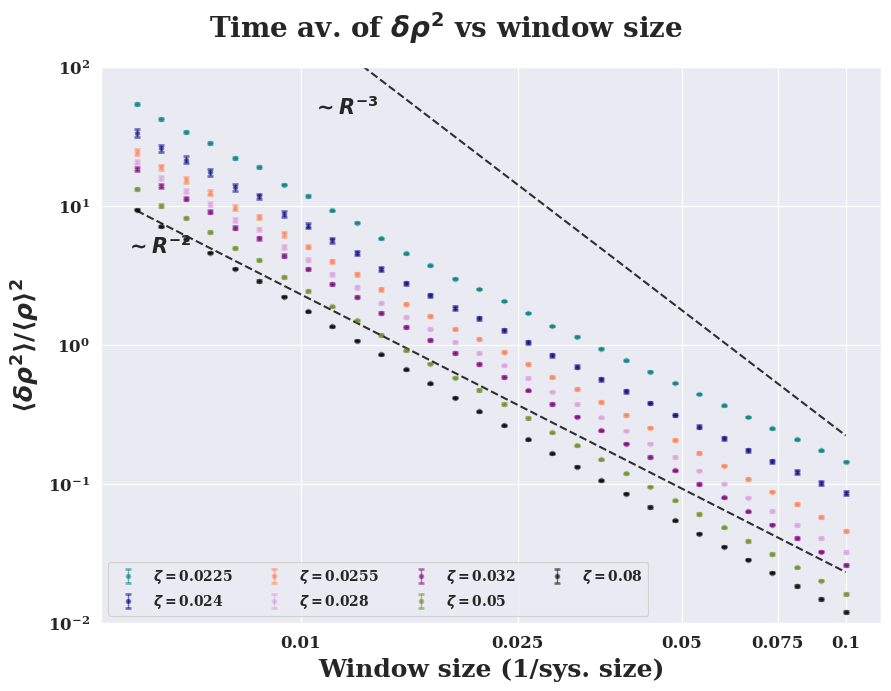

In [210]:

fig, ax = plt.subplots(figsize=(9,7))
for i, act in enumerate(act_list):
    if act < 0.0225 or act > 0.1:
        continue
    if i % 3 != 0:
        continue
    frames_av_dens = np.mean(dens_fluc_av[first_frame_list[i]:, min_window_idx:,i], axis = 0)
    frames_av_dens_std = np.mean(dens_fluc_std[first_frame_list[i]:, min_window_idx:,i], axis = 0) \
                      / np.sqrt(Nframes_non_nan_counts[i])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
        fit = do_chi2_fit(fit_func, np.log(R), np.log(frames_av_dens), frames_av_dens_std / frames_av_dens, param_guess, verbose = False)

    Ndof, chi2, prop = get_statistics_from_fit(fit, len(R), subtract_1dof_for_binning = False)
 #   ax.plot(R, np.exp(fit_func(np.log(R), *fit.values[:])), '-', alpha = 0.2, lw=1)
    fit_params_time_av[i, :Nparams] = fit.values[:]
    fit_params_time_av[i, Nparams:] = fit.errors[:]
    stat_arr_time_av[i, :] = Ndof, chi2, prop


    ax.errorbar(window_sizes[min_window_idx:], frames_av_dens, \
                frames_av_dens_std, fmt='.', label = fr'$\zeta = ${act}',\
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

ax.plot(window_sizes[min_window_idx:], (frames_av_dens[0] * window_sizes[min_window_idx] ** 2 -1)  / window_sizes[min_window_idx:] ** (2), '--', color='black', alpha=0.8, lw = 1.5)
ax.text(0.03, 0.7, r'$\sim R^{-2}$', fontsize=15, transform=ax.transAxes, verticalalignment='top', fontweight='normal')

ax.plot(window_sizes[min_window_idx:], 30000/ window_sizes[min_window_idx:] ** (3), '--', color='black', alpha=0.8, lw = 1.5)
ax.text(0.27, 0.95, r'$\sim R^{-3}$', transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight='normal')

ax.set_xlabel('Window size (1/sys. size)')
ax.set_ylabel(rf'$\langle \delta \rho ^2 \rangle /  \langle \rho \rangle ^2$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bottom=0.01, top = 100)
xticks = np.array([1, 2.5, 5, 7.5, 10]) * 5.12
ax.set_xticks(xticks, labels = np.round(xticks / 512,3))
ax.legend(ncol=4, fontsize = 10, loc = 'lower left') 

fig.suptitle(rf'Time av. of $ \delta \rho^2$ vs window size')
fig.tight_layout()

print(fit_params_time_av[:,0])
print(stat_arr_time_av[:,-1])

np.save(os.path.join(save_path, f'fit_params_{save_suffix}_normalize{normalize}_time_av.npy'), fit_params_time_av)
np.save(os.path.join(save_path, f'stat_arr_{save_suffix}_normalize{normalize}_time_av.npy'), stat_arr_time_av)

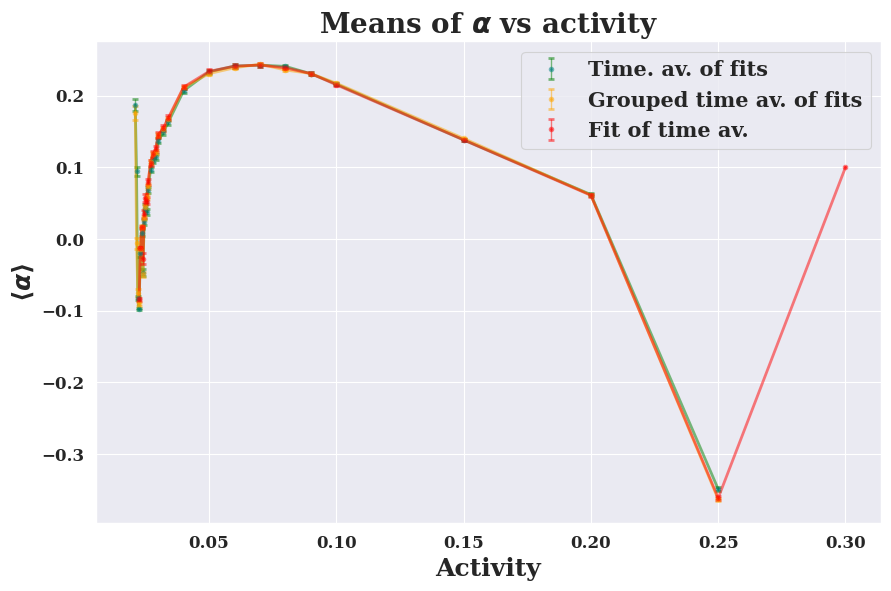

In [103]:
# calc weighted mean and error on mean for all frames and activities

Ngroup = 5
group = True
weighted_means_list = []
weighted_errs_list = []
weighted_means_group_list = []
weighted_errs_group_list = []

for i, act in enumerate(act_list):
        if act < act_list[min_act_idx]:
               continue
        
        if group:
                x = fit_params[first_frame_list[i]:, i, 0]

                max_idx = len(x) - len(x) % Ngroup
                # group the data and calculate the weighted mean and error on mean
                x_group = x[:max_idx].reshape(-1, Ngroup).mean(axis=1)
                dx_group = np.std(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)

                mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x_group, dx_group)
                weighted_means_group_list.append(mean)
                weighted_errs_group_list.append(err)
      
        if 1:
             #   p_mask = (0.05 < stat_arr[first_frame_list[i]:, i, 2])  
                x = fit_params[first_frame_list[i]:, i, 0][p_mask]
                dx = fit_params[first_frame_list[i]:, i, Nparams][p_mask]

        try:
                mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x, dx)
                weighted_means_list.append(mean)
                weighted_errs_list.append(err)
        except:
                print("No fits for activity = {}".format(act))
                weighted_means_list.append(np.nan)
                weighted_errs_list.append(np.nan)


fig2, ax2 = plt.subplots(figsize=(9,6))
ax2.errorbar(act_list[min_act_idx:], weighted_means_list, weighted_errs_list, fmt='.', label = 'Time. av. of fits', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='green')
ax2.plot(act_list[min_act_idx:], weighted_means_list, '-', color='green', alpha=0.5, )
ax2.errorbar(act_list[min_act_idx:], weighted_means_group_list, weighted_errs_group_list, fmt='.', label = 'Grouped time av. of fits', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='orange', color = 'orange')
ax2.plot(act_list[min_act_idx:],weighted_means_group_list,  '-',color='orange', alpha=0.5)
ax2.errorbar(act_list[min_act_idx:], fit_params_time_av[min_act_idx:,0], fit_params_time_av[min_act_idx:,Nparams], fmt='.', label = 'Fit of time av.', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='red', color = 'red'
             )
ax2.plot(act_list[min_act_idx:], fit_params_time_av[min_act_idx:,0], '-', color='red', alpha=0.5)

ax2.set_xlabel('Activity')
ax2.set_ylabel(rf'$\langle\alpha \rangle$')
ax2.set_title(rf'Means of $\alpha $ vs activity')
ax2.legend()
fig2.tight_layout()

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_11684\3434580222.py:7: RuntimeWarning: Mean of empty slice
  dens_fluc_av2 = np.nanmean(dens_fluc2, axis=3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_11684\3434580222.py:17: RuntimeWarning: Mean of empty slice
  xi_av =  np.nanmean(dens_fluc_av2, axis = 0) # /( av_defects[:,0] * LX ** 2) #* window_sizes[:, None]**2  #** 2
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_11684\3434580222.py:57: RuntimeWarning: Mean of empty slice
  xi_av_vals_mean = np.nanmean(xi_av_vals, axis = 0)


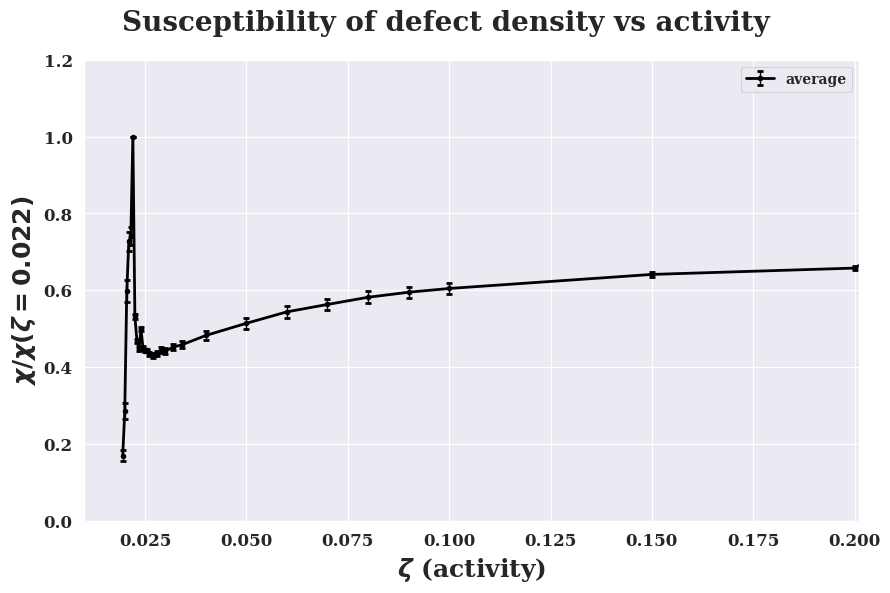

In [190]:
dens_fluc2 = np.load(os.path.join(save_path, 'dens_fluc.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
dens_fluc2 = dens_fluc2 * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]

av_dens_arr = defect_arr
dens_fluc2 = dens_fluc2 / av_dens_arr[:, None, :, :] ** 2

dens_fluc_av2 = np.nanmean(dens_fluc2, axis=3)
dens_fluc_std2 = np.nanstd(dens_fluc2, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

if 0:
    av_density_all_windows2 = av_defects_conv[:, 0] 
    dens_fluc_av2 = dens_fluc_av2 / av_density_all_windows2[:, None, :] ** 2
    dens_fluc_std2 = dens_fluc_std2 / av_density_all_windows2[:, None, :] ** 2

logplot = False

xi_av =  np.nanmean(dens_fluc_av2, axis = 0) # /( av_defects[:,0] * LX ** 2) #* window_sizes[:, None]**2  #** 2
xi_std = np.nanstd(dens_fluc_av2, axis = 0, ddof=1) / np.sqrt(Nframes_non_nan_counts[np.newaxis, :]) #* window_sizes[:, None]**2 #** 2

xi_av[:, act_idx_very_long_lower:act_idx_very_long] = np.loadtxt(os.path.join(save_path, 'xi_av_full_very_long.txt'))[:, :]
xi_std[:, act_idx_very_long_lower:act_idx_very_long] = np.loadtxt(os.path.join(save_path, 'xi_std_full_very_long.txt'))[:, :]
xi_av[:, act_idx_long-2:act_idx_long] = np.loadtxt(os.path.join(save_path, 'xi_av_full_long.txt'))[:, -2:]
xi_std[:, act_idx_long-2:act_idx_long] = np.loadtxt(os.path.join(save_path, 'xi_std_full_long.txt'))[:, -2:]

#np.save(os.path.join(save_path, 'xi_av_full.npy'), xi_av)
#np.save(os.path.join(save_path, 'xi_std_full.npy'), xi_std)


xi_av *= ( av_defects[:,0] * LX ** 2) 
xi_std *= ( av_defects[:,0] * LX ** 2) 
fig, ax = plt.subplots(figsize=(9,6))

min_act_cutoff_idx = 0
min_window_cutoff_idx = 0

max_window_cutoff_idx = -1

act_max_idx = act_list.index(0.022)


if 1:

  xi_av_vals = np.zeros( (len(window_sizes[min_window_cutoff_idx:max_window_cutoff_idx]), len(act_list[min_act_cutoff_idx:]) ))
  xi_std_vals = np.zeros( (len(window_sizes[min_window_cutoff_idx:max_window_cutoff_idx]), len(act_list[min_act_cutoff_idx:]) ))
  for j, window in enumerate(window_sizes[min_window_cutoff_idx:]):
        if window >= window_sizes[max_window_cutoff_idx]:
            continue
        norm = xi_av[j + min_window_cutoff_idx, act_max_idx]
        if j  % 4 == 0 and j < 0: #in [1,2,3,4,5,6,7]:
            ax.errorbar(act_list[min_act_cutoff_idx:], xi_av[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm,\
                            xi_std[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm, label=f'WS = {np.round(window / 256,3)}', fmt='.', \
                  capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
        xi_av_vals[j,:] = xi_av[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm
        xi_std_vals[j,:] = xi_std[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm

  # plot average xi
  xi_av_vals_mean = np.nanmean(xi_av_vals, axis = 0)
  xi_av_vals_std = np.nanstd(xi_av_vals, axis = 0) / np.sqrt(xi_av_vals.shape[0])
  ax.errorbar(act_list[min_act_cutoff_idx:], xi_av_vals_mean, xi_av_vals_std, label='average', fmt='.-', \
                  capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 1, markersize=4, color='black')
  ax.set_xlabel(rf'$\zeta$ (activity)')
  ax.set_ylabel(rf'$\chi  / \chi (\zeta = {act_list[act_max_idx]}) $')
  ax.set_xlim(0.01,0.201)
  ax.set_ylim(0, 1.2)
  #ax.set_xscale('log')
  if logplot:
    #  ax.set_yscale('log')
      ax.set_xscale('log')

  #add legend above the plot in 3 rows
  ax.legend(loc='upper right', ncol=5, fontsize = 10,)
  fig.suptitle(rf'Susceptibility of defect density vs activity', fontsize=20)
  fig.tight_layout()
  plt.show()

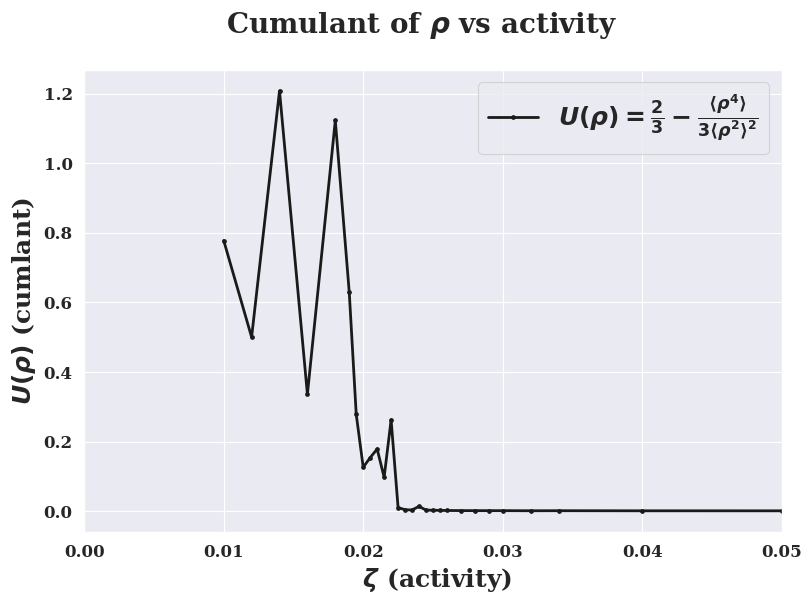

In [127]:
binder_tot = 1 - np.nanmean(np.nanmean(defect_arr[:,:,:] ** 4, axis = -1), axis = 0) \
  / (3 * np.nanmean(np.nanmean(defect_arr[:,:,:] ** 2, axis = -1), axis = 0) ** 2)


binder_tot[act_idx_very_long_lower:act_idx_very_long] = np.loadtxt(os.path.join(save_path, 'binder_tot_very_long.txt'))[:]
binder_tot[act_idx_long-2:act_idx_long] = np.loadtxt(os.path.join(save_path, 'binder_tot_long.txt'))[-2:]

# save
np.save(os.path.join(save_path, f'binder_tot.npy'), binder_tot)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(act_list, 2/3 - binder_tot, 'k.-', label=r'$U(\rho) = \frac{2}{3} - \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2}$')

ax.set_xlim(0, 0.05)
ax.set_xlabel(r' $\zeta$ (activity)')
ax.set_ylabel(r'$U(\rho)$ (cumlant)')
ax.legend(loc='upper right', ncol=2, fontsize = 18)
fig.suptitle(rf'Cumulant of $\rho$ vs activity', fontsize=20)

plt.show()